In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

In [2]:
from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo

In [3]:
Trials = 5
for unitary_seed in range(Trials):
    initial_pops = [.02,0.02, .02, .02, .499, .02, .02, .02]
    system = DM.n_thermal_qbits(initial_pops)
    connectivity = "c5"
    unitary_energy_subspace = 1
    ordering_seed = 1
    chunk_size = 2
    order_rule_name = "greedy"
    num_steps = 50
    data = cleo.execute(file_name="greedy",
                       connectivity=connectivity,
                       order_rule_name = order_rule_name, 
                       unitary_seed=unitary_seed,
                       unitary_energy_subspace=unitary_energy_subspace,
                       evolution_generation_type="unitary",
                       chunk_size=chunk_size,
                       num_steps=num_steps,
                       initial_pops=initial_pops,
                       verbosity = .9)

90%
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_greedy
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_greedy
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_greedy
90%
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_1-order_rule_name_greedy
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_1-order_rule_name_greedy
simulation complete, extracting and saving data to : ../data/greedy/greedy-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_1-order_rule_name_greedy
90%
simu

In [4]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/greedy")

In [32]:
Trials = 5
for unitary_seed in range(Trials):
    initial_pops = [.02,0.02, .02, .02, .499, .02, .02, .02]
    system = DM.n_thermal_qbits(initial_pops)
    connectivity = "c5"
    unitary_energy_subspace = 1
    ordering_seed = 1
    chunk_size = 2
    order_rule_name = "random"
    num_steps = 50
    data = cleo.execute(file_name="random",
                       connectivity=connectivity,
                       order_rule_name = order_rule_name, 
                       unitary_seed=unitary_seed,
                       unitary_energy_subspace=unitary_energy_subspace,
                       evolution_generation_type="unitary",
                       chunk_size=chunk_size,
                       num_steps=num_steps,
                       initial_pops=initial_pops,
                       verbosity = .9)

90%
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_random
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_random
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_0-order_rule_name_random
90%
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_1-order_rule_name_random
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_1-order_rule_name_random
simulation complete, extracting and saving data to : ../data/random/random-8_qubits-c5_connectivity-unitary_energy_subspace_1-unitary_seed_1-order_rule_name_random
90%
simu

In [33]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/random")

In [5]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM

In [6]:
newdata1 = dict(h5py.File("../data/greedy/greedy.hdf5"))

In [34]:
newdata2 = dict(h5py.File("../data/random/random.hdf5"))

In [7]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_3_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(3)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit triplet
    #dimension 3 and 4 is the 3 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['three_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [111]:
twoQdmsrandom = get_2_qbit_dms(newdata1,8,"c5","greedy")

In [112]:
twoQdmsrandom = get_2_qbit_dms(newdata2,8,"c5","random")

In [ ]:
twoQdmsweakm = get_2_qbit_dms(newdata3,8,"c5","weakest_maximizes")

In [12]:
popsgreedy = get_pops(newdata1,8,"c5","greedy")

In [37]:
popsrandom = get_pops(newdata2,8,"c5","random")

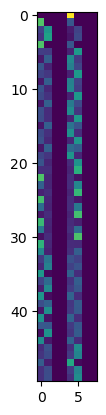

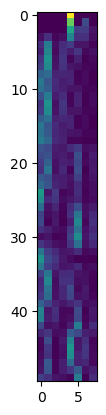

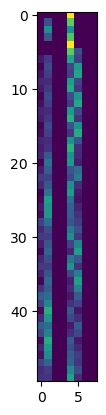

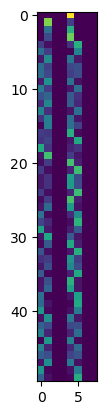

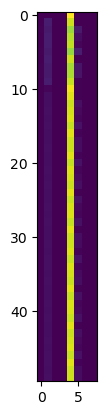

In [13]:
for i in range(5):
    plt.imshow(popsgreedy[i], interpolation='none')
    plt.show()

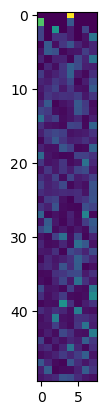

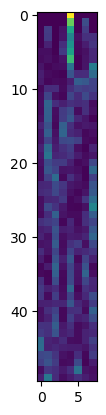

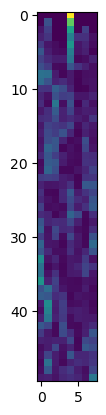

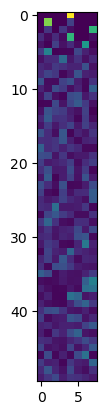

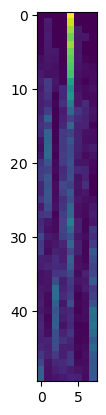

In [38]:
for i in range(5):
    plt.imshow(popsrandom[i], interpolation='none')
    plt.show()

In [14]:
#MI of every pair
def mutual_info_dicts(twoQdms, trial_index):
    mutual_info_list = []
    for time_step in twoQdms[trial_index]:
        mutual_info_dict = {}
        mutual_info = measure.mutual_information_of_every_pair_dict(time_step)
        # Filter out values below the precision threshold
        filtered_mutual_info = {k: v if v >= 1e-6 else 0 for k, v in mutual_info.items()}
        # Update the mutual_info_dict with the filtered mutual info for the current time step
        mutual_info_dict.update(filtered_mutual_info)
        # Append the mutual_info_dict to the list
        mutual_info_list.append(mutual_info_dict)
    return mutual_info_list

In [15]:
# Call the two_point_dict function for each trial index
# Get the list of dictionaries containing two point values for each time step
def create_adjacency_matrix_two_dim(two_point_dict, num_nodes):
    adjacency_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for (node1, node2), two_point_value in two_point_dict.items():
        adjacency_matrix[node1][node2] = two_point_value
        adjacency_matrix[node2][node1] = two_point_value  # Assuming undirected graph
    return adjacency_matrix


In [18]:
def adjacency_matrices_list_two_dim(twoQdms, trial_index, num_nodes, two_point_dicts):
    # Get the list of dictionaries containing mutual information values for each time step
    two_point_dicts_list = two_point_dicts(twoQdms, trial_index)
    # Create adjacency matrices for each time step
    adjacency_matrices = []
    for two_point_dict in two_point_dicts_list:
        adj_matrix = create_adjacency_matrix_two_dim(two_point_dict, num_nodes)
        adjacency_matrices.append(adj_matrix)
    return adjacency_matrices

In [93]:
# Example usage:
# Assuming num_nodes is known
num_nodes = 8  # Update this with the actual number of nodes
# Get the list of adjacency matrices
adj_matrices_list = adjacency_matrices_list_two_dim(twoQdmsgreedy,2, num_nodes,mutual_info_dicts)
adj_matrices_list_random = adjacency_matrices_list_two_dim(twoQdmsrandom,2, num_nodes,mutual_info_dicts)
adj_matrices_list_weakm = adjacency_matrices_list_two_dim(twoQdmsrandom,2, num_nodes,mutual_info_dicts)

#adj_matrices_list

In [77]:
#Clustering Coefficient
adj_matrix_greedy=np.array(adjacency_matrices_list_two_dim(twoQdmsgreedy,2,8,mutual_info_dicts))
adj_matrix_random=np.array(adjacency_matrices_list_two_dim(twoQdmsrandom,2,8,mutual_info_dicts))
def clustering_coeff_function_of_time(adjacency_matrix_list):
    C_list = []
    for adj_mat in adjacency_matrix_list:
        M_sq = adj_mat@adj_mat
        sum_of_M_sq = np.sum(M_sq)
        M_cube = adj_mat@adj_mat@adj_mat
        M_cube_trace = np.trace(M_cube)
        C_list.append(M_cube_trace/sum_of_M_sq)
    return(C_list)
    

In [137]:
#Disparity
adj_matrix_greedy=np.array(adjacency_matrices_list_two_dim(twoQdmsgreedy,2,8,mutual_info_dicts))
adj_matrix_random=np.array(adjacency_matrices_list_two_dim(twoQdmsrandom,2,8,mutual_info_dicts))
def disparity_function_of_time(adjacency_matrix_list, N):
    D_list = []
    for adj_mat in adjacency_matrix_list:
        M_row_sum_squared = np.sum(adj_mat, axis=1)**2
        M_row_sum_of_squared_elements = np.sum(adj_mat**2, axis=1)
        # Check for zero division before performing division
        Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)
        D_list.append(np.sum(Di) / N)
    return D_list

In [138]:
disparity_function_of_time(adj_matrix_greedy,8)
#clustering_coeff_function_of_time(adj_matrix_greedy)

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_37466/195550909.py:10: RuntimeWarning: invalid value encountered in divide
  Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)


[0.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.38027682600239576,
 0.20605446902040261,
 0.24410227747227708,
 0.21644975101944772,
 0.19593028828926118,
 0.20449852567769755,
 0.23607998355978912,
 0.21576893579160167,
 0.19728869583663466,
 0.20675600315223266,
 0.23526299555211555,
 0.22724814396625093,
 0.19455836486998232,
 0.2049953575302167,
 0.1949221508632753,
 0.2999748983014452,
 0.1838629096267495,
 0.17293108719391134,
 0.1901750910562347,
 0.2781123399273425,
 0.2670185273564035,
 0.21938922522972526,
 0.23399444995179042,
 0.17449770754909774,
 0.18345129371693059,
 0.18403740768569662,
 0.19663732331537886,
 0.2992012452514185,
 0.18400798216137285,
 0.19147413456781953,
 0.18961989588798145,
 0.31375416731634415,
 0.18525617790745874,
 0.18907159134829837,
 0.17706265685022338,
 0.27322784719320037,
 0.19545860724490882,
 0.1875976787171197,
 0.18166829925552264,
 0.2607769507177966,
 0.20119008620735518,
 0.2164152424388285,
 0.17421740978687156,
 0.1817857966452046,
 0.1900871

In [78]:
Clustering_greedy = clustering_coeff_function_of_time(adj_matrix_greedy)
Clustering_random = clustering_coeff_function_of_time(adj_matrix_random)

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_37466/629912739.py:11: RuntimeWarning: invalid value encountered in scalar divide
  C_list.append(M_cube_trace/sum_of_M_sq)


In [140]:
#plot 2 lists a function of time
def plot_lists_as_function_of_time(list1, list2):
    # Assuming both lists have the same length (representing time steps)
    time_steps = range(1, len(list1) + 1)
    
    # Plotting the lists
    plt.plot(time_steps, list1, label='Greedy')
    plt.plot(time_steps, list2, label='Random')
    
    # Adding labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Clustering Coefficient as a Function of Time Step')
    
    # Adding legend
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.show()


/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_37466/195550909.py:10: RuntimeWarning: invalid value encountered in divide
  Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)


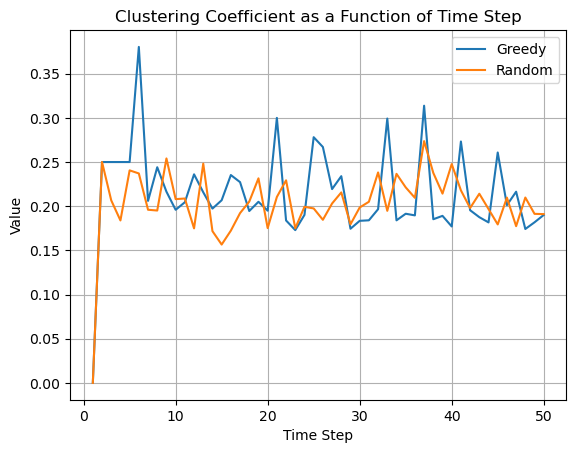

In [142]:
plot_lists_as_function_of_time(disparity_function_of_time(adj_matrix_greedy,8)
,disparity_function_of_time(adj_matrix_random,8))

In [83]:
#node strength
def average_values_two_point_list(adj_matrices_list):
    average_values_two_point_list=[]
    for adj_matrix in adj_matrices_list:
        adj_matrix_form = np.matrix(adj_matrix)
        average_values_two_point = adj_matrix_form.sum(axis=1)
        average_values_two_point=np.array(average_values_two_point).flatten()
        average_values_two_point=np.real(average_values_two_point)
        average_values_two_point_list.append(average_values_two_point)
    return average_values_two_point_list

In [104]:
def plot_each_array_separately(list_of_arrays):
    # Iterate over each array in the list
    for i, array in enumerate(list_of_arrays):
        # Create a new figure for each array
        plt.figure(figsize=(8, 6))
        
        # Plot the array
        plt.plot(array)
        
        # Add labels and title
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.title(f'Array {i+1} as Function of Time Step')
        
        # Show the plot
        plt.grid(True)
        plt.show()

In [106]:
def plot_arrays_from_two_sets(set1, set2):
    num_arrays = len(set1)
    
    # Iterate over each array in both sets
    for i in range(num_arrays):
        # Create a new figure for each array
        plt.figure(figsize=(8, 6))
        
        # Plot arrays from both sets on the same chart
        plt.plot(set1[i], label='Set 1')
        plt.plot(set2[i], label='Set 2')
        
        # Add labels and title
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.title(f'Arrays from Set 1 and Set 2 as Function of Time Step')
        
        # Add legend
        plt.legend()
        
        # Show the plot
        plt.grid(True)
        plt.show()


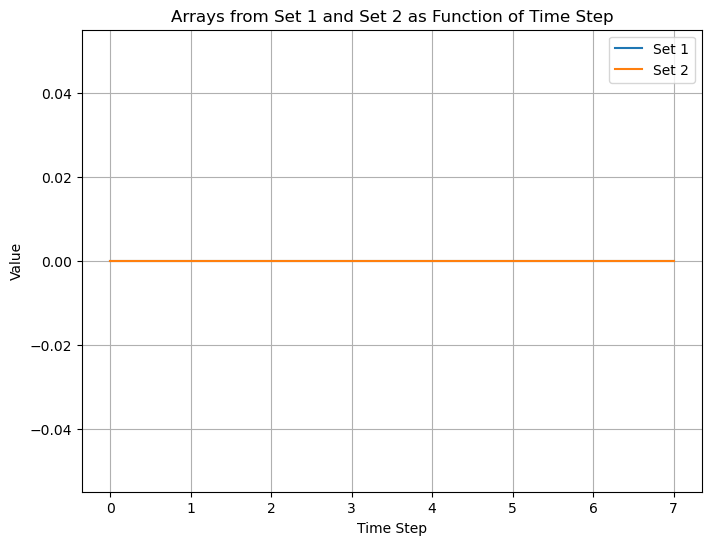

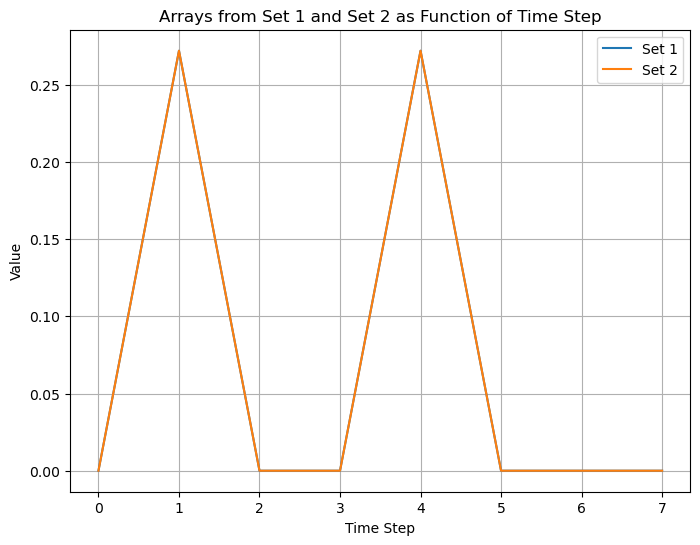

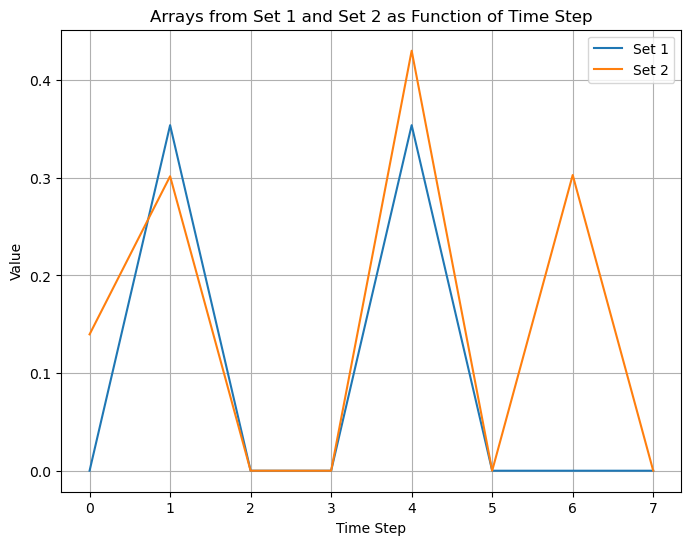

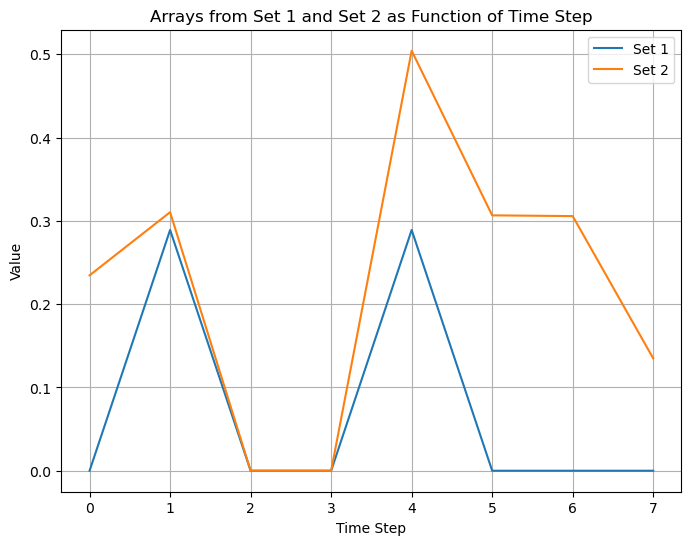

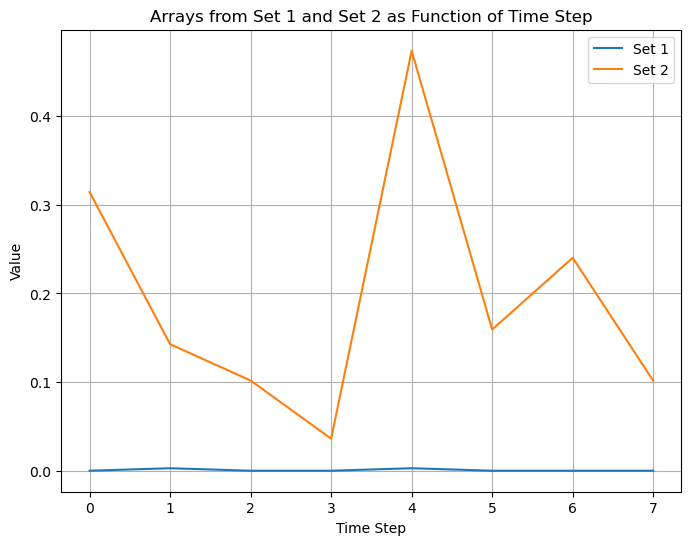

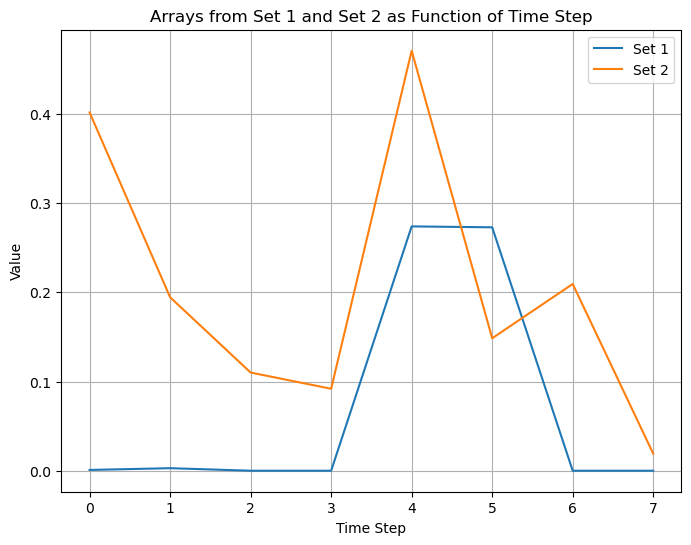

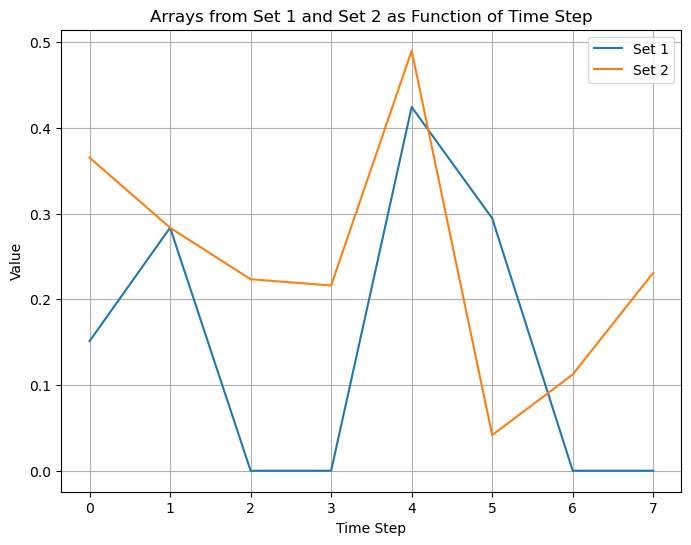

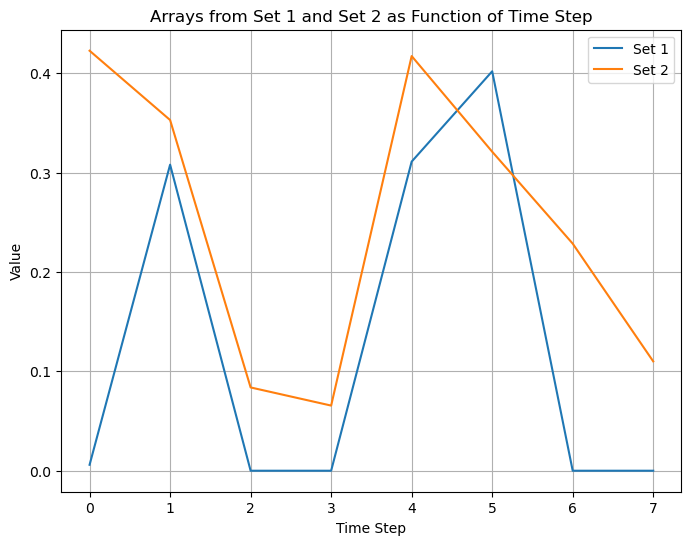

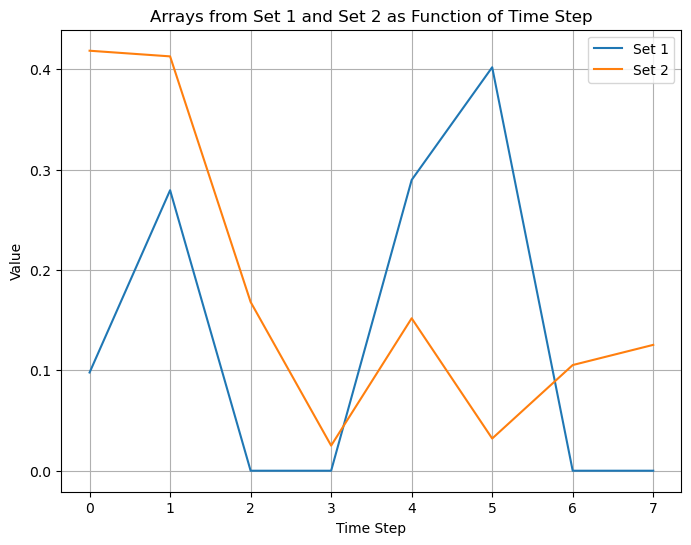

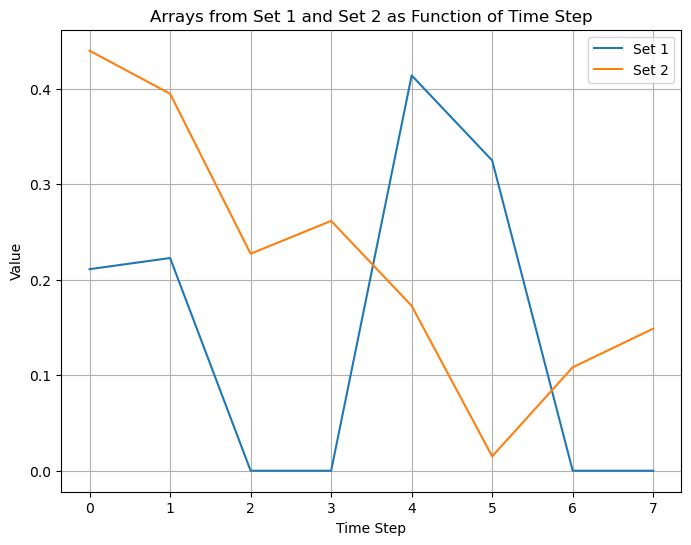

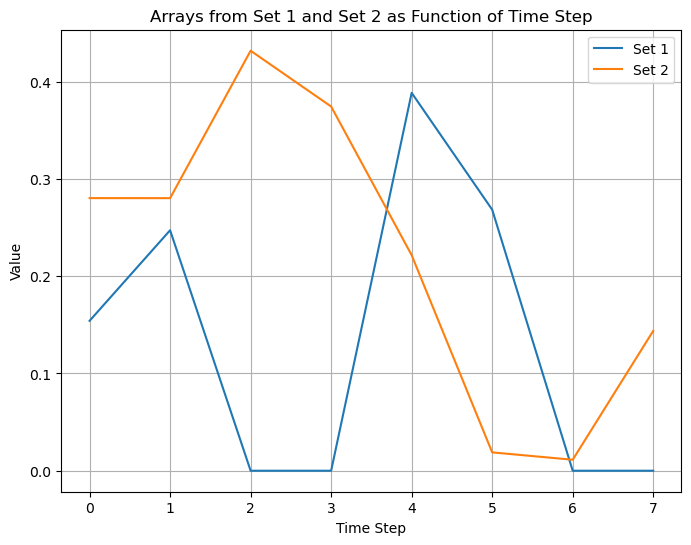

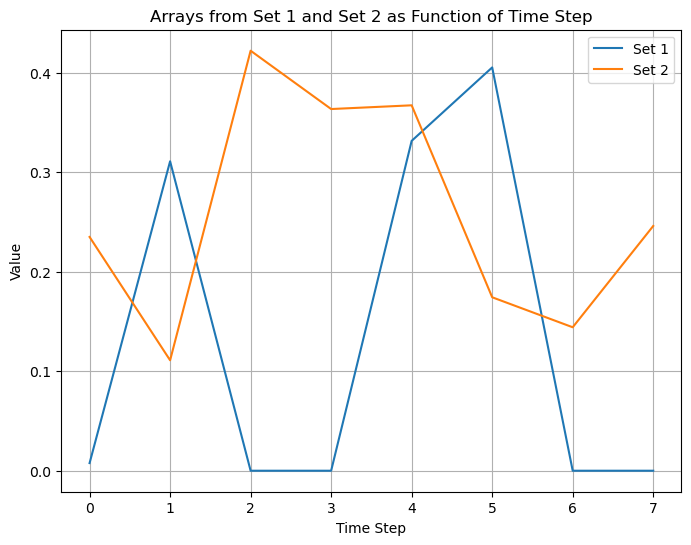

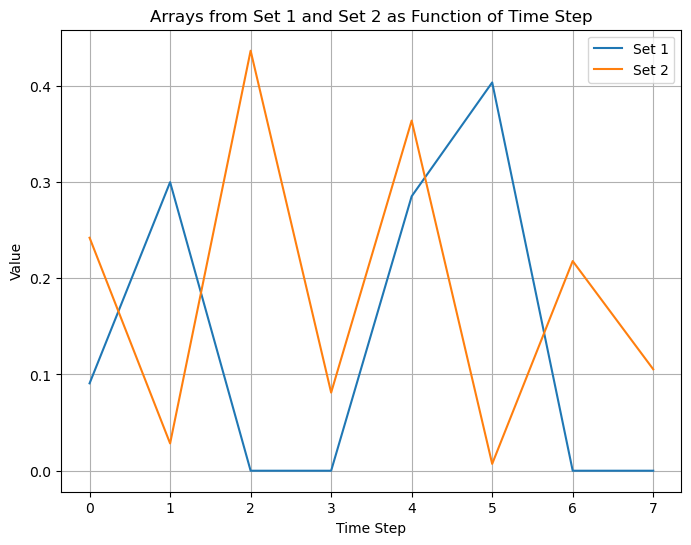

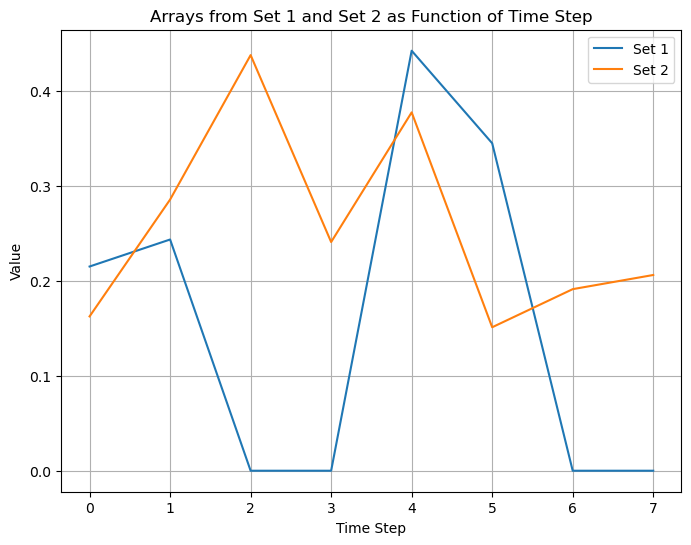

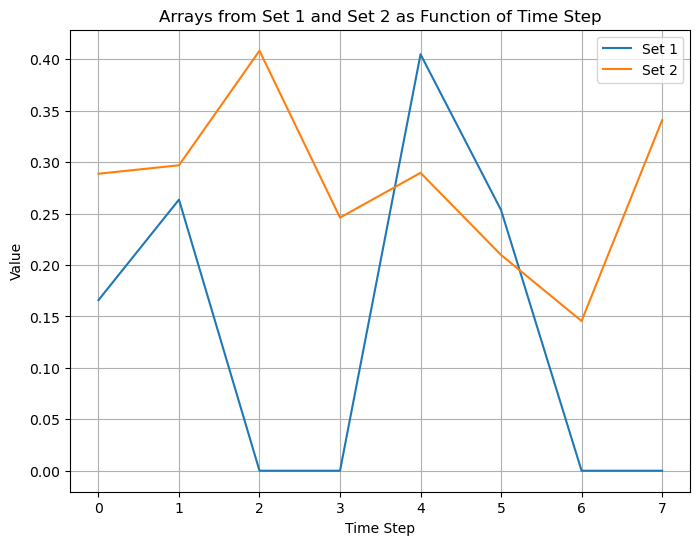

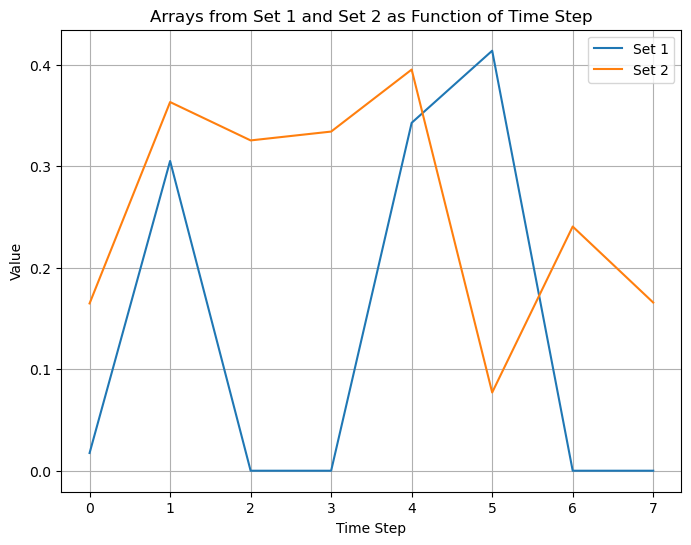

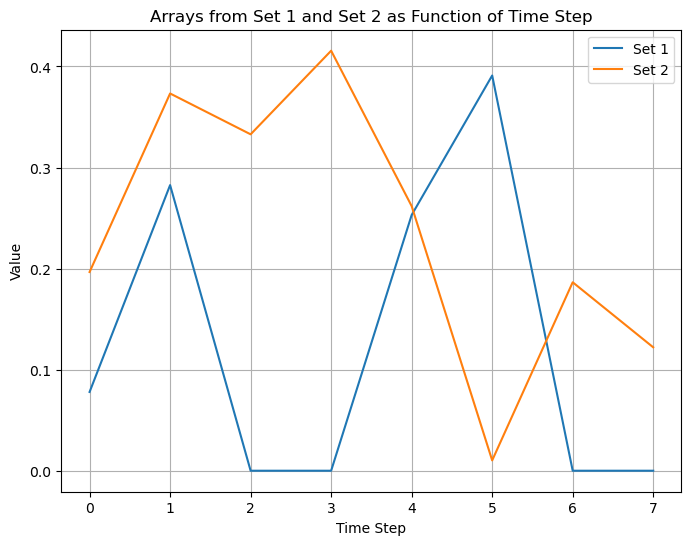

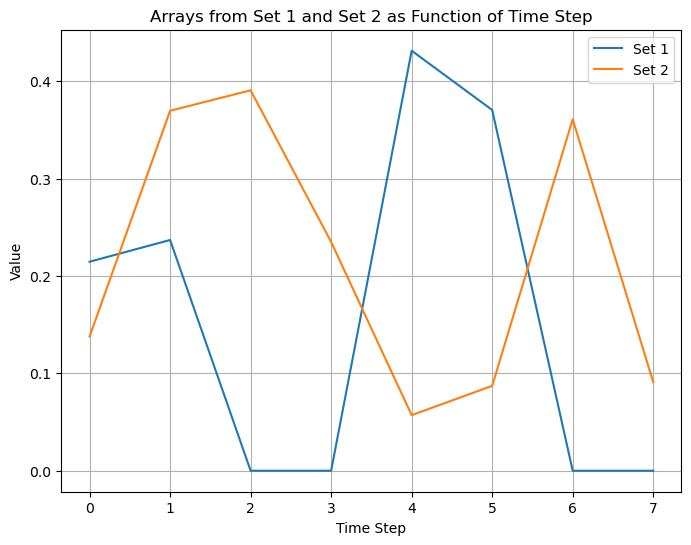

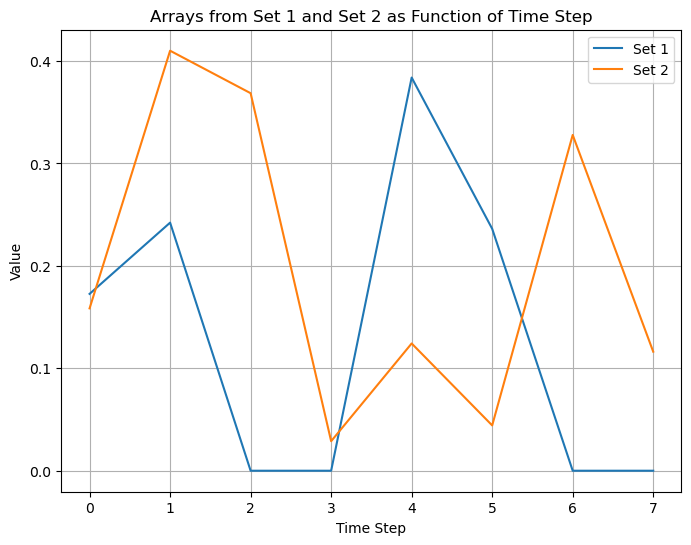

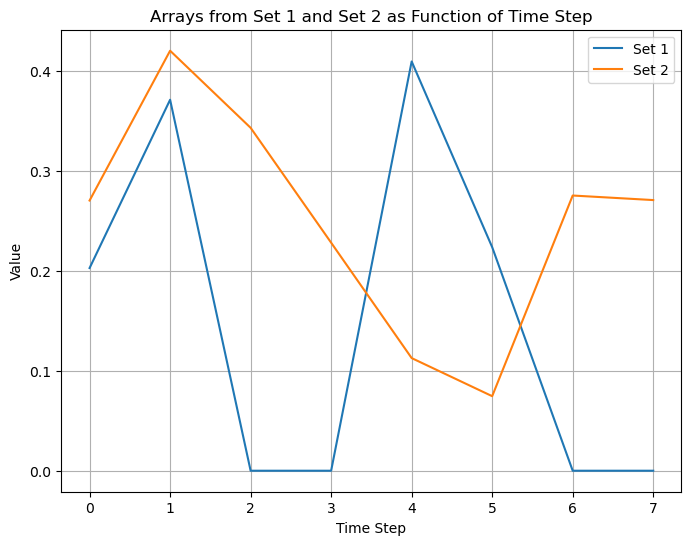

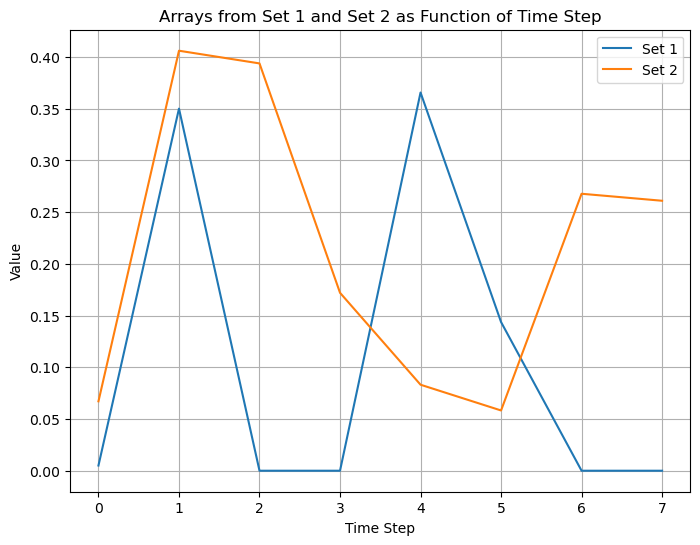

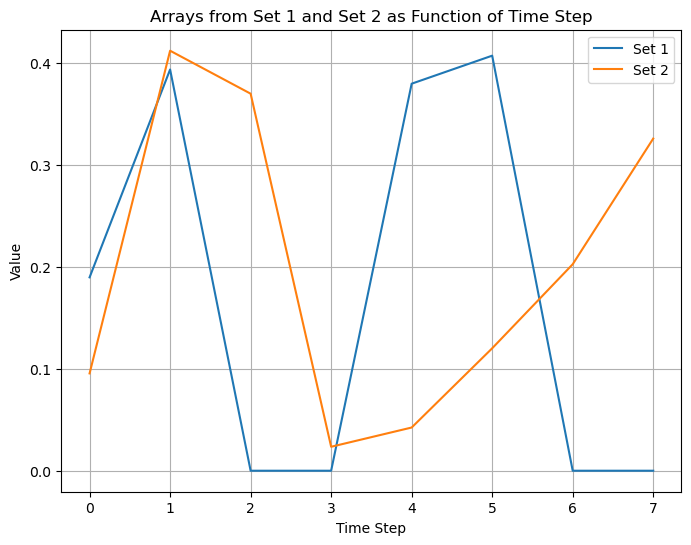

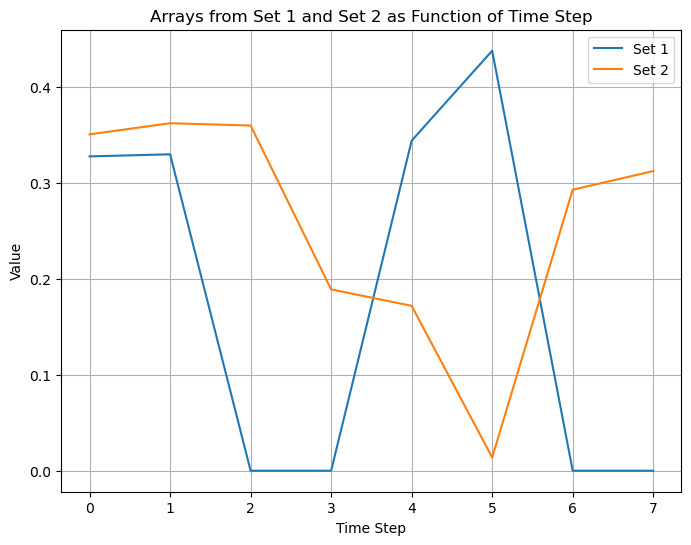

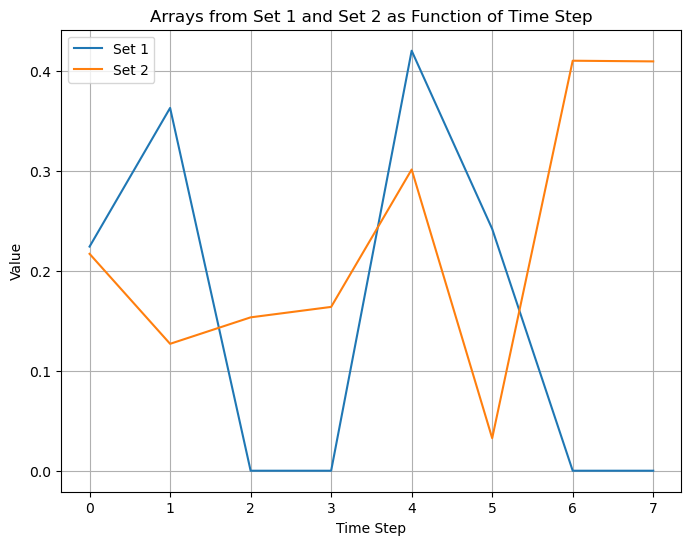

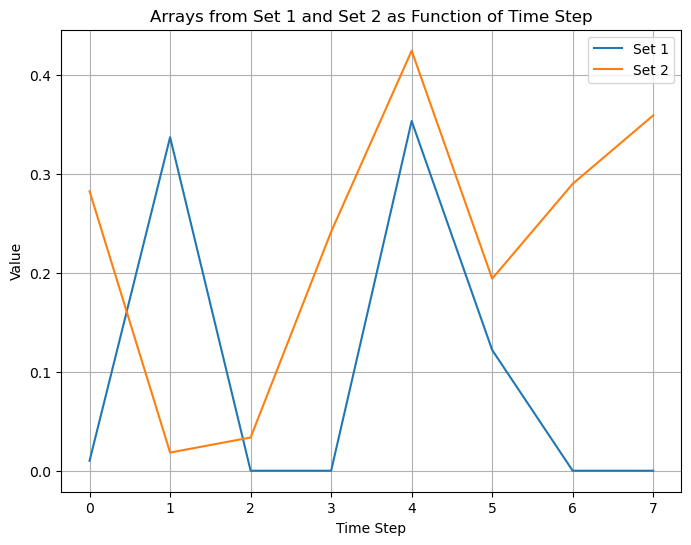

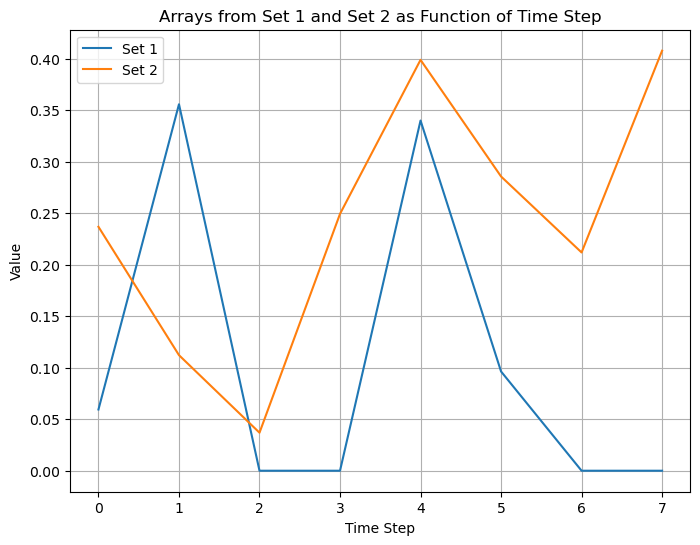

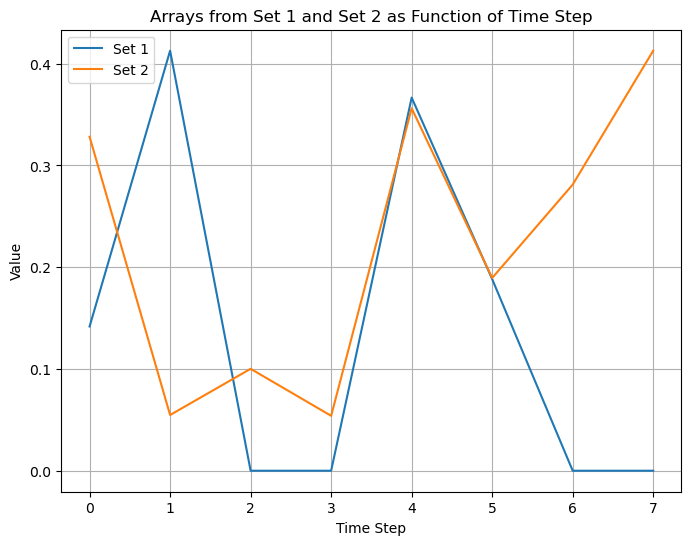

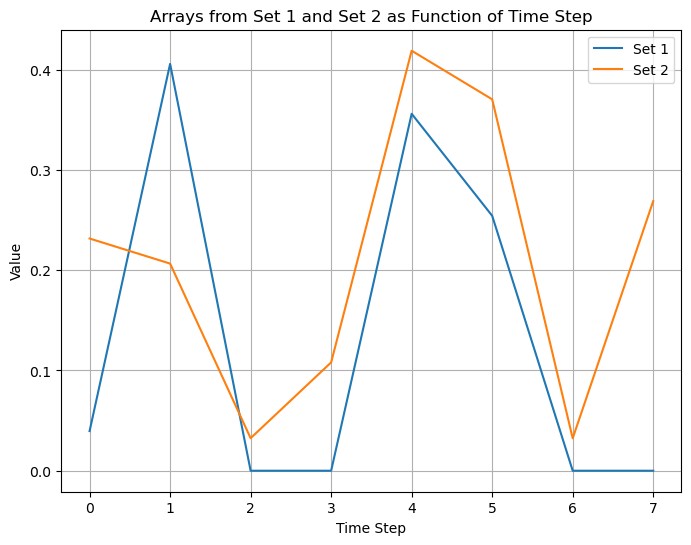

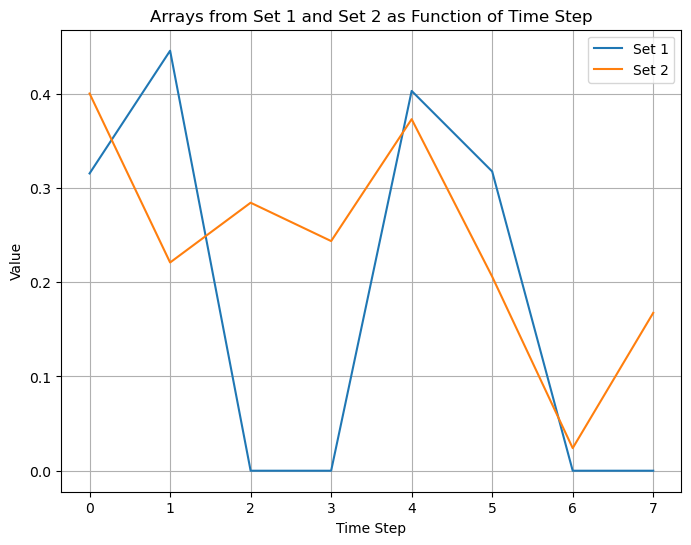

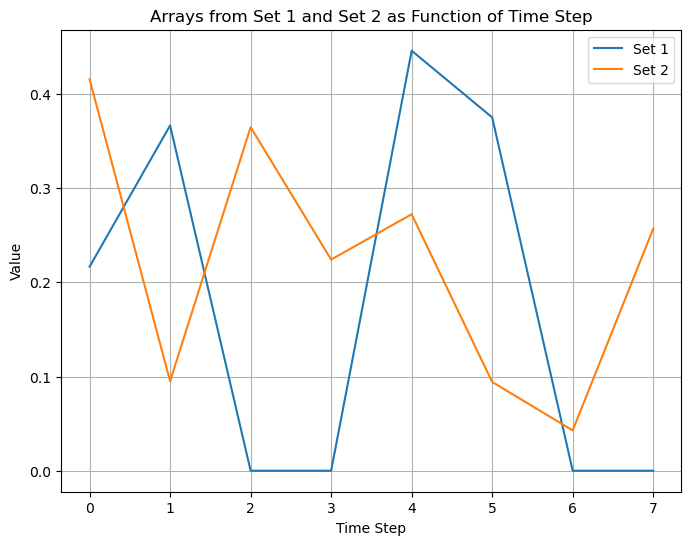

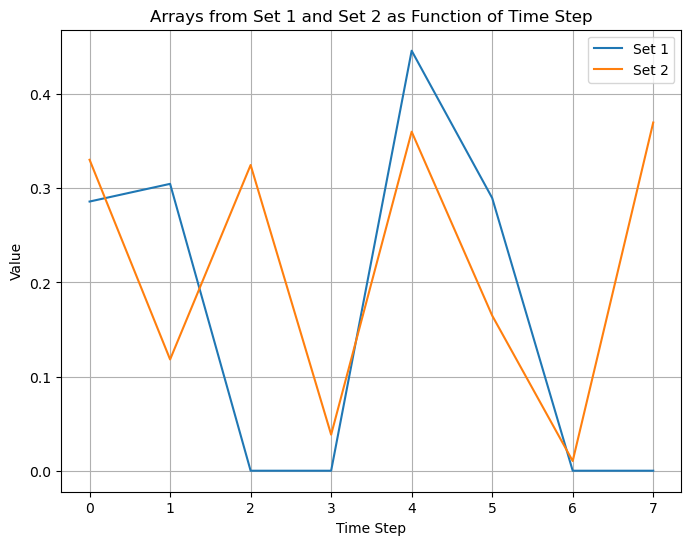

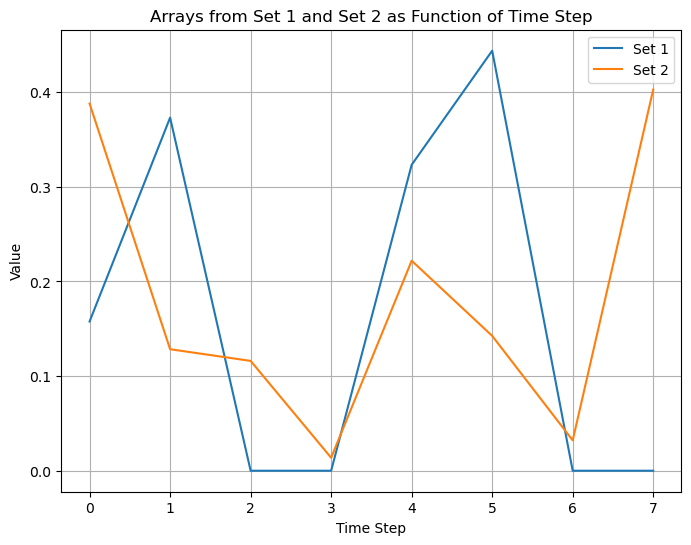

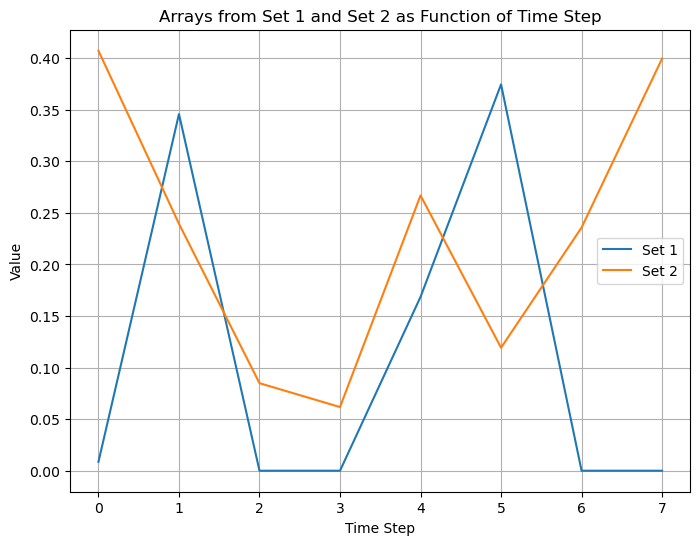

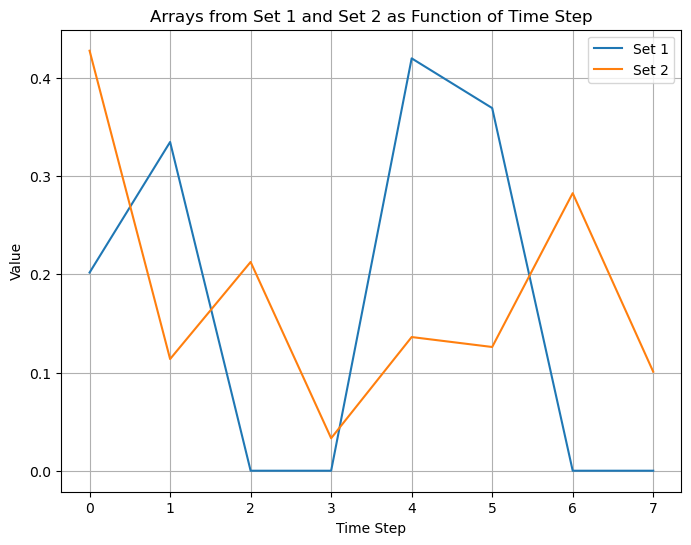

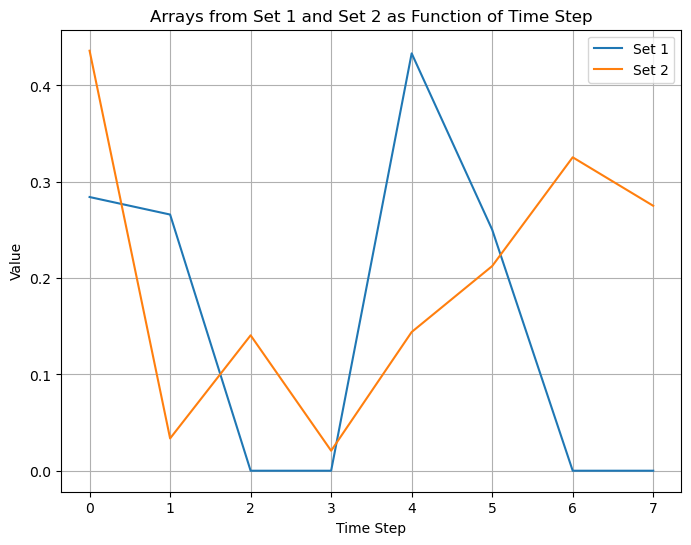

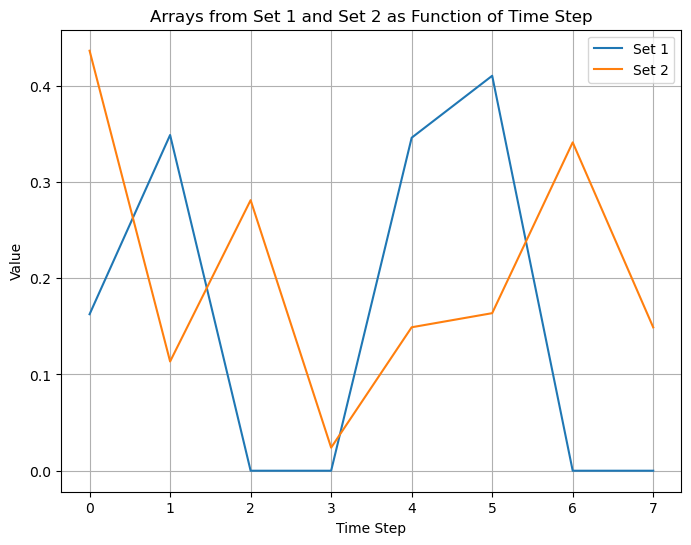

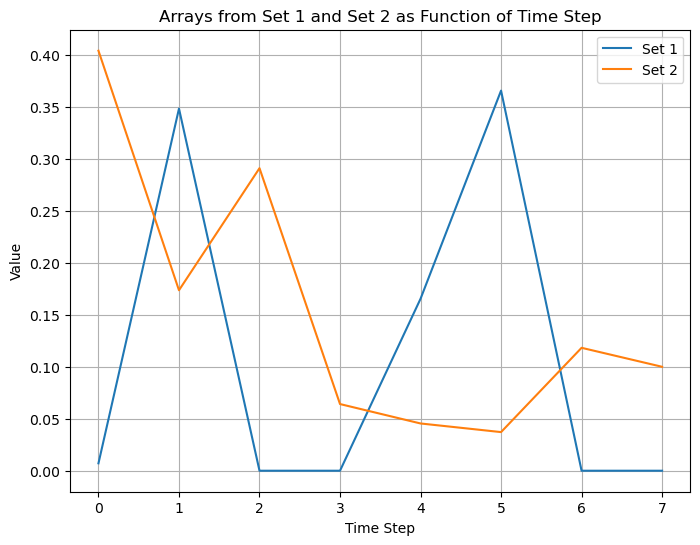

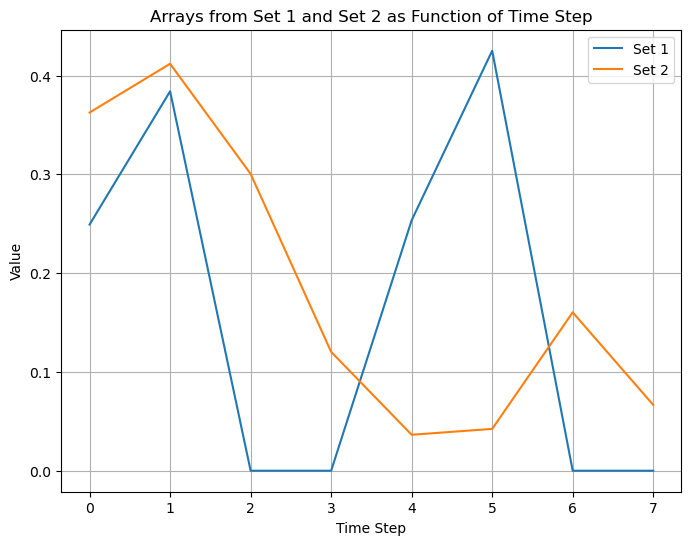

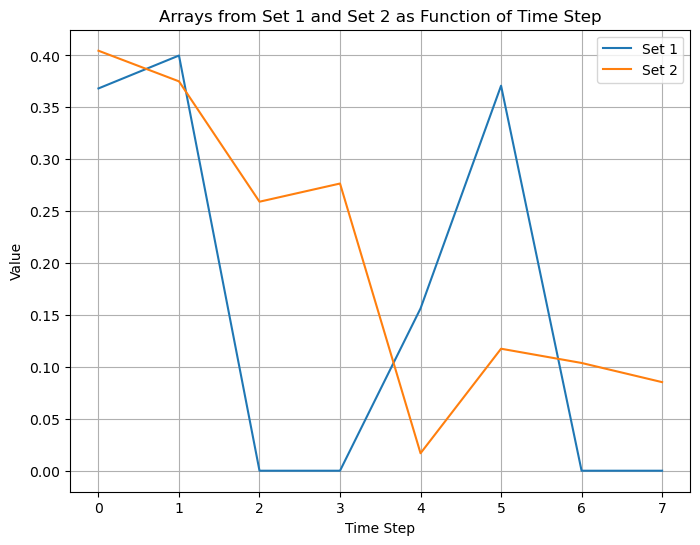

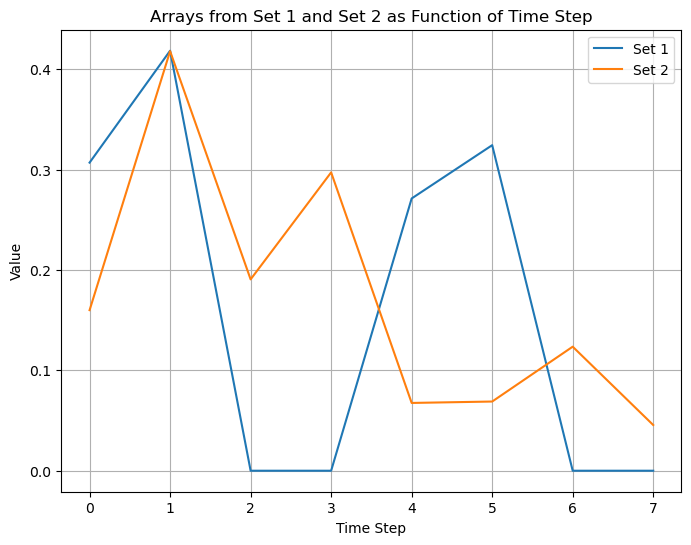

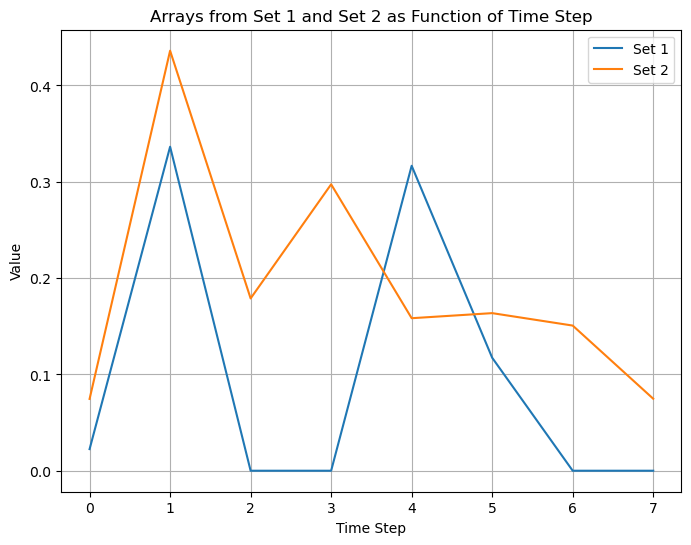

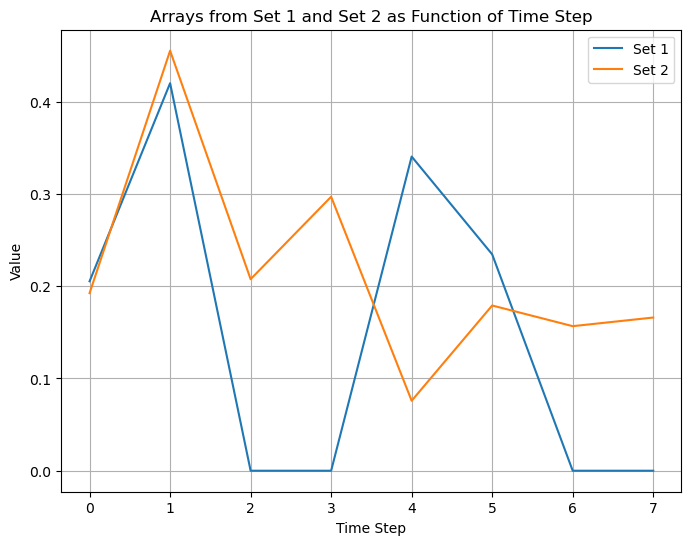

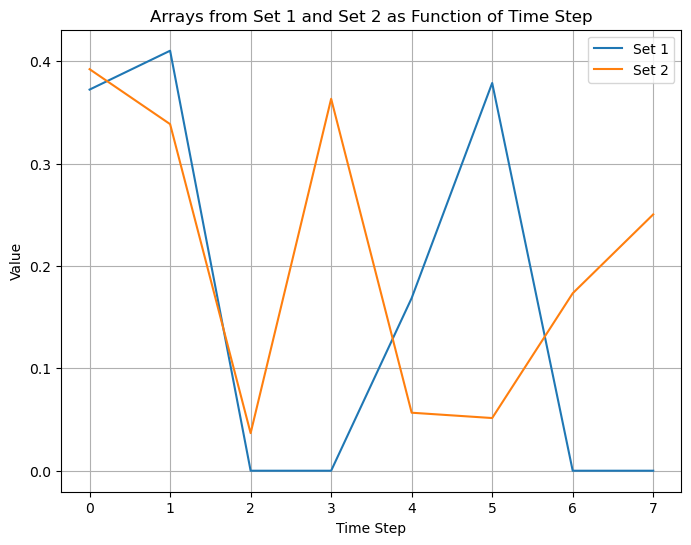

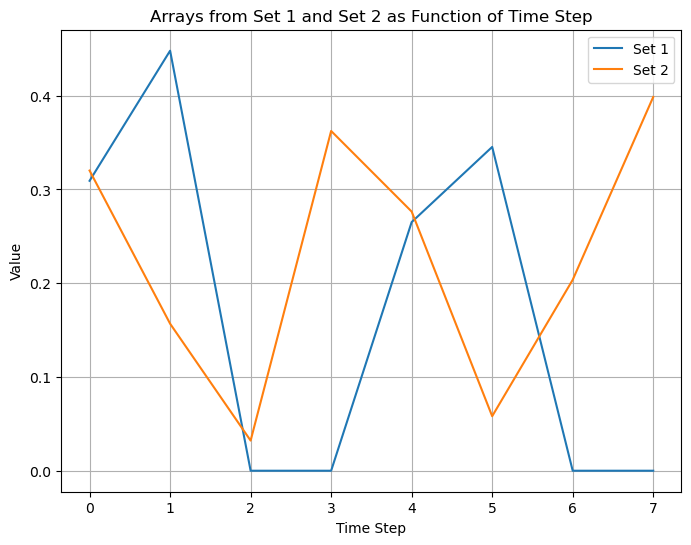

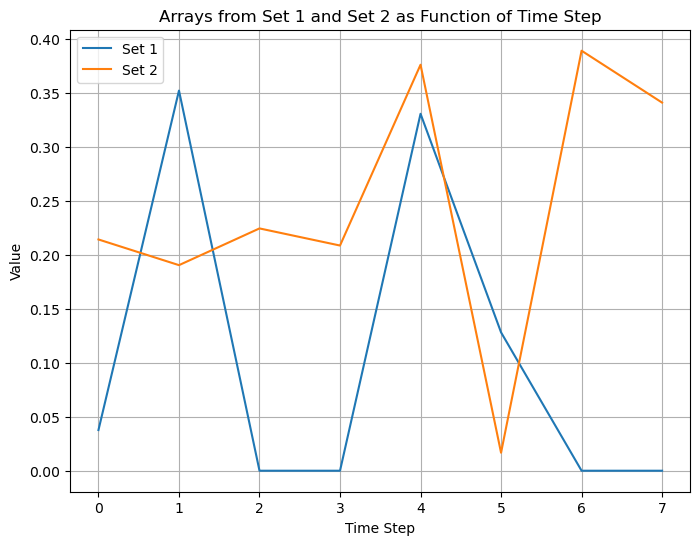

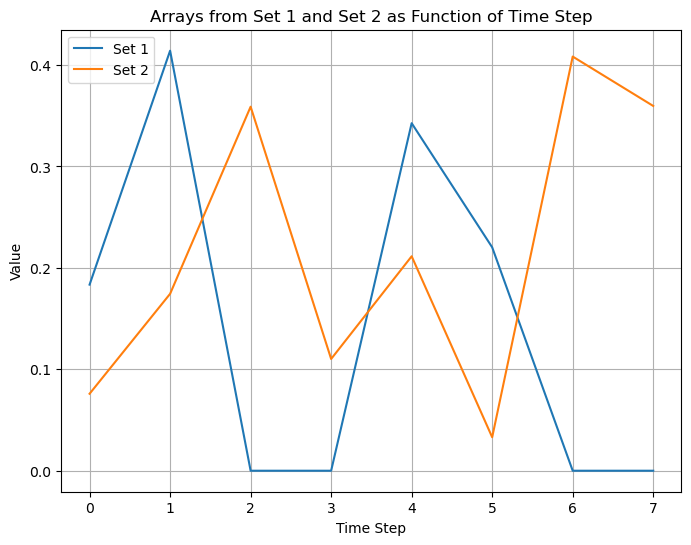

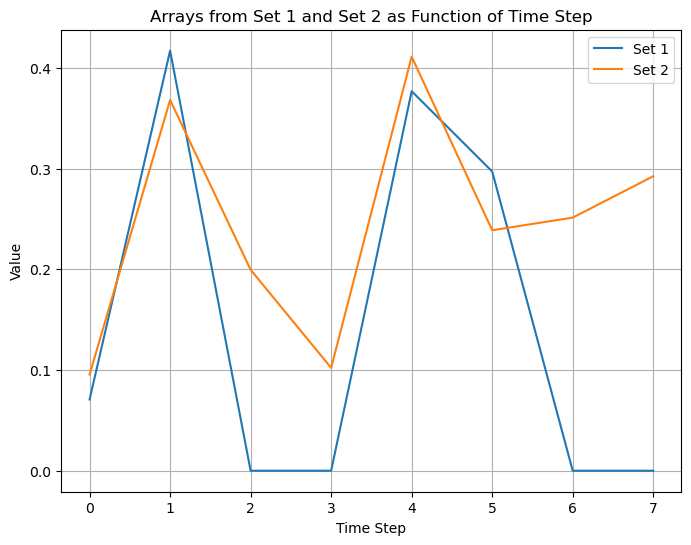

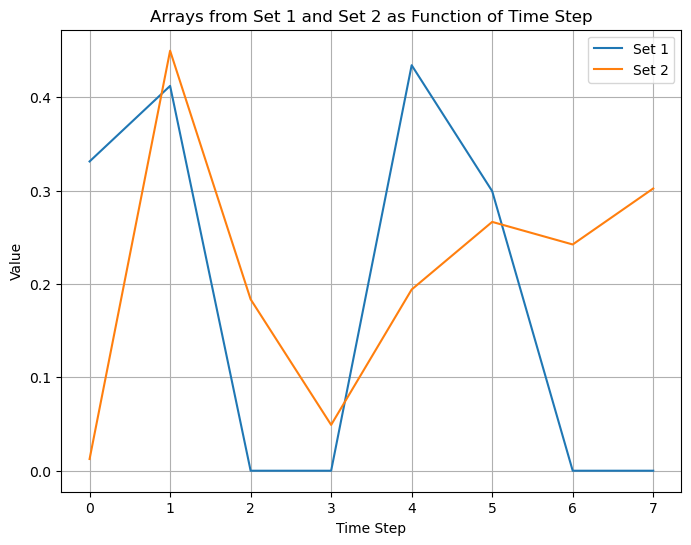

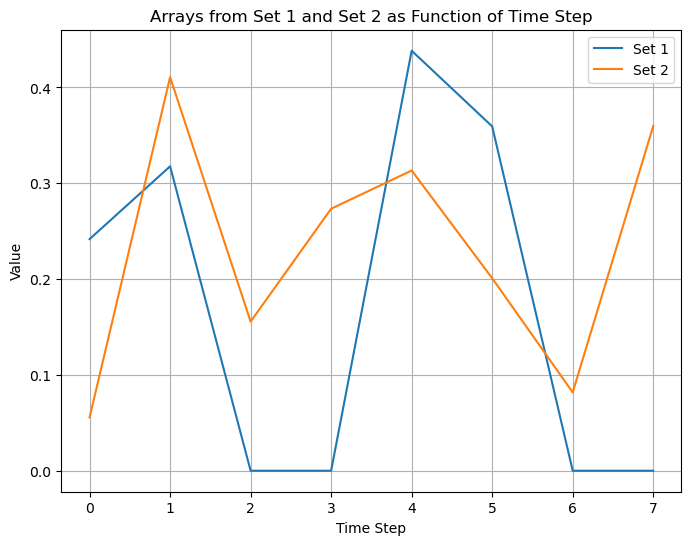

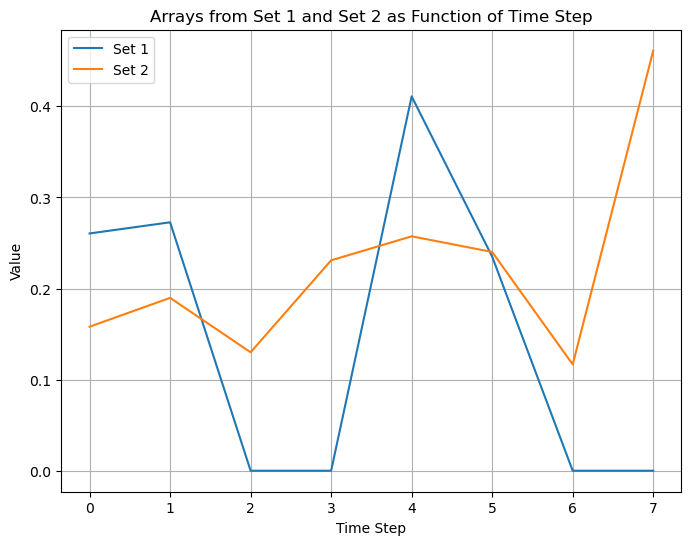

In [107]:
plot_arrays_from_two_sets(average_values_two_point_list(adj_matrices_list),average_values_two_point_list(adj_matrices_list_random))

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

NameError: name 'change_in_ex_work' is not defined